# Training simple multilayer percepton (MLP) on the MNIST dataset

Notes:
    * Adaptive learning was not working in that case, probably because of the noise of the gradient between batches. 
    * Normalizing by Lmax seems to be the best working optimizer for me.

## Setup

In [31]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import tensorflow as tf
tf.__version__

'1.8.0'

In [64]:
import sys
sys.path.append("../src/")
import keras_mnist_mlp as mlp
import tf_optimizer as tf_opt
import callbacks as clb
import utils as ut
from plotting import set_display_settings
set_display_settings()

from keras.optimizers import TFOptimizer
from keras.callbacks import History

## Dataset and model definition

In [34]:
x_train, y_train, validation_set, input_shape = mlp.get_dataset()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model function:
    * 30 dense layers of size 128. 
    * After each layer Batchnormalization is applied then dropout at level 0.2
    * Small l2 regularization is added to the weights of the network

In [35]:
def model_fn():
    model = mlp.get_mlp(num_layers=30, lantent_size=128, activation='relu', l2_reg=1e-5)
    return model

model = model_fn()
batch_size = 64

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_302 (Dense)            (None, 128)               100480    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_303 (Dense)            (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# Train model with `LmaxNormalizedSGD`

Some notes: 

* `LmaxNormalizedSGD` just normalizes gradients by their $L_\infty$ norm for each layer.
* No momentum is used, since it did not improve results for this case..

In [73]:
model = model_fn()
metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.001, 0.0001]:
    optimizer = TFOptimizer(tf_opt.LmaxNormalizedSGD(lr=lr))
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=batch_size, epochs=10, 
        validation_data=validation_set, 
        callbacks=metrics_history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 91s 2ms/step - loss: 2.0584 - acc: 0.2677 - val_loss: 1.1883 - val_acc: 0.6142
Epoch 2/10
60000/60000 [==============================] - 35s 587us/step - loss: 1.0508 - acc: 0.6697 - val_loss: 0.7380 - val_acc: 0.7304
Epoch 3/10
60000/60000 [==============================] - 35s 589us/step - loss: 0.9134 - acc: 0.7046 - val_loss: 0.6692 - val_acc: 0.7414
Epoch 4/10
60000/60000 [==============================] - 35s 589us/step - loss: 0.8551 - acc: 0.7166 - val_loss: 0.6110 - val_acc: 0.7643
Epoch 5/10
60000/60000 [==============================] - 35s 588us/step - loss: 0.8166 - acc: 0.7219 - val_loss: 0.6145 - val_acc: 0.7622
Epoch 6/10
60000/60000 [==============================] - 35s 591us/step - loss: 0.7927 - acc: 0.7684 - val_loss: 0.5411 - val_acc: 0.8334
Epoch 7/10
60000/60000 [==============================] - 36s 592us/step - loss: 0.7446 - acc: 0.7913 - val_loss: 0.61

Plotting:

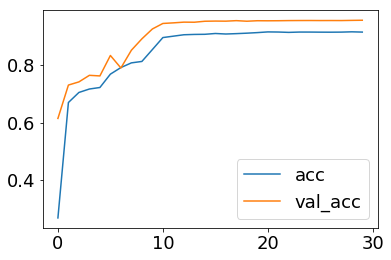

In [109]:
hist = metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Training with Adam optimizer and SGD with momentum (0.9)

For Adam I use slightly smaller learning rate since it was perfoming better for me. Propably one could get better results by doing grid search on the initial value of `lr`.

In [75]:
from keras.optimizers import Adam, SGD

In [77]:
model = model_fn()
optimizer = Adam(lr=0.001)
adam_metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]
# lr=0.01 was not training properly, the validation loss was dropping after some epochs
for lr in [0.005, 0.001, 0.0001]:
    optimizer = Adam(lr=lr)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=batch_size, epochs=10, 
        validation_data=validation_set, 
        callbacks=adam_metrics_history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 61s 1ms/step - loss: 2.1170 - acc: 0.2385 - val_loss: 1.2621 - val_acc: 0.5533
Epoch 2/10
60000/60000 [==============================] - 36s 604us/step - loss: 1.2794 - acc: 0.5642 - val_loss: 0.8532 - val_acc: 0.7320
Epoch 3/10
60000/60000 [==============================] - 36s 604us/step - loss: 0.9999 - acc: 0.6945 - val_loss: 0.6526 - val_acc: 0.8082
Epoch 4/10
60000/60000 [==============================] - 37s 614us/step - loss: 0.9282 - acc: 0.7424 - val_loss: 0.7231 - val_acc: 0.7971
Epoch 5/10
60000/60000 [==============================] - 36s 606us/step - loss: 0.9701 - acc: 0.7382 - val_loss: 0.7267 - val_acc: 0.8160
Epoch 6/10
60000/60000 [==============================] - 36s 604us/step - loss: 1.0227 - acc: 0.7135 - val_loss: 1.0088 - val_acc: 0.7156
Epoch 7/10
60000/60000 [==============================] - 37s 611us/step - loss: 1.1092 - acc: 0.6965 - val_loss: 0.92

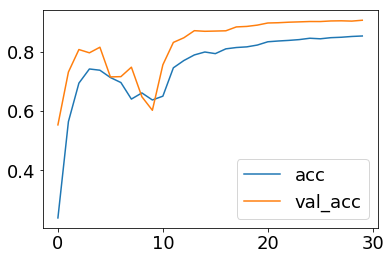

In [108]:
hist = adam_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Training with SGD and momentum

In [79]:
from keras.optimizers import SGD
model = model_fn()
momentum_metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.001, 0.0001]:
    optimizer = SGD(lr=lr,  momentum=0.9)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=batch_size, epochs=10, 
        validation_data=validation_set, 
        callbacks=momentum_metrics_history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 62s 1ms/step - loss: 3.6362 - acc: 0.1654 - val_loss: 3.2451 - val_acc: 0.2862
Epoch 2/10
60000/60000 [==============================] - 35s 591us/step - loss: 3.3170 - acc: 0.2768 - val_loss: 2.9878 - val_acc: 0.3664
Epoch 3/10
60000/60000 [==============================] - 35s 587us/step - loss: 3.1558 - acc: 0.3219 - val_loss: 2.8781 - val_acc: 0.3770
Epoch 4/10
60000/60000 [==============================] - 36s 594us/step - loss: 3.0717 - acc: 0.3424 - val_loss: 2.8261 - val_acc: 0.4210
Epoch 5/10
60000/60000 [==============================] - 35s 588us/step - loss: 3.0030 - acc: 0.3581 - val_loss: 2.7451 - val_acc: 0.4045
Epoch 6/10
60000/60000 [==============================] - 35s 588us/step - loss: 2.9452 - acc: 0.3730 - val_loss: 2.7113 - val_acc: 0.4576
Epoch 7/10
60000/60000 [==============================] - 35s 588us/step - loss: 2.8924 - acc: 0.3926 - val_loss: 2.64

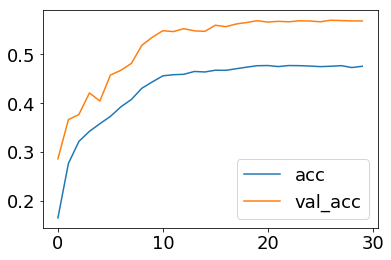

In [110]:
hist = momentum_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0:
        plt.plot(v, label=k)
plt.legend()

# Plots for comparison

In [81]:
hists = {
  'NSGD': metrics_history,
  'Adam': adam_metrics_history,
  'Momentum': momentum_metrics_history
} 

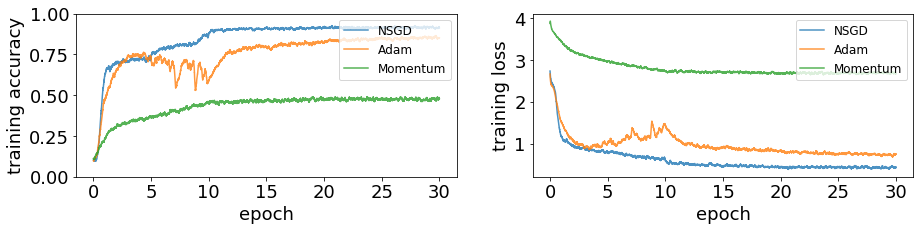

In [101]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[0].monitor_values['accuracies']['acc']
    h = ut.moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, 30, len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.ylim([0, 1])
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('training accuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[0].monitor_values['losses']['loss']
    h = ut.moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, 30, len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('training loss')
# plt.savefig('../img/mnist_mlp_training.pdf')
# plt.savefig('../img/mnist_mlp_training.png')

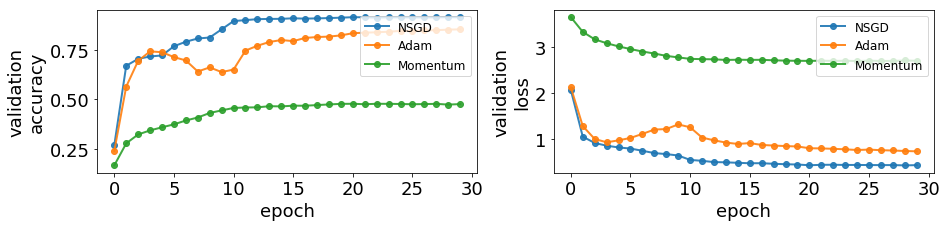

In [102]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[1].monitor_values['accuracies']['val_acc']
    plt.plot(h, 'o-',label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('validation\naccuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[1].monitor_values['losses']['val_loss']
    plt.plot(h, 'o-', label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('validation\nloss')
# plt.savefig('../img/mnist_mlp_validation.pdf')
# plt.savefig('../img/mnist_mlp_validation.png')